<a href="https://colab.research.google.com/github/oliverquintana/UnetSegmentation/blob/master/TumorUNET_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNET Tumor Segmentation

# Load libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2
from google.colab.patches import cv2_imshow


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Dataset

1156 Training Images

*   578 Brain MRI 
*   578 Tumor masks

126 Validation Images

*   63 Brain MRI 
*   63 Tumor masks

In [2]:
def get_images(mypath, size = 256, channels = 1):

    onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
    onlyfiles.sort()
    images = np.empty(len(onlyfiles), dtype=object)
    images = np.zeros((len(onlyfiles), size, size))

    for n in range(len(onlyfiles)):
        images[n] = cv2.imread( join(mypath,onlyfiles[n]), 0)
        #images[n] = cv2.resize(temp, (size, size), interpolation = cv2.INTER_AREA)
        
    print(len(images))
    return images

training_images_path = "/content/drive/My Drive/Data/images"
training_labels_path = "/content/drive/My Drive/Data/masks"
validation_images_path = "/content/drive/My Drive/Dataset MRI/tumor_images"
validation_labels_path = "/content/drive/My Drive/Dataset MRI/tumor_masks"

training_images = get_images(training_images_path)
training_masks = get_images(training_labels_path)
validation_images = get_images(validation_images_path)
validation_masks = get_images(validation_labels_path)

578
578
63
63


# Dataset Visualization

MRI


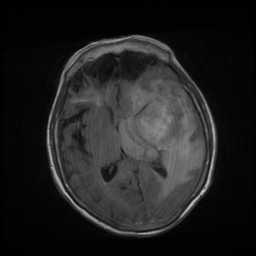

Tumor Segmentation


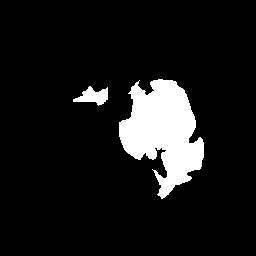

In [3]:
print("MRI")
cv2_imshow(training_images[30])
print("Tumor Segmentation")
cv2_imshow(training_masks[30])

# Dataset Normalization

In [4]:
x_train = training_images.reshape(training_images.shape[0], 256, 256, 1)
x_test = validation_images.reshape(validation_images.shape[0], 256, 256, 1)
y_train = training_masks.reshape(training_masks.shape[0], 256, 256, 1)
y_test = validation_masks.reshape(validation_masks.shape[0], 256, 256, 1)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train = y_train.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(578, 256, 256, 1)
(578, 256, 256, 1)
(63, 256, 256, 1)
(63, 256, 256, 1)


# UNET Model

In [5]:
input_img = Input(shape=(256, 256, 1))

# Encoder
# Step 1
conv1 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(input_img)
conv1 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2))(conv1)
# Step 2
conv2 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(pool1)
conv2 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2))(conv2)
# Step 3
conv3 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(pool2)
conv3 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2))(conv3)
# Step 4
conv4 = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(pool3)
conv4 = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size = (2,2))(conv4)
# Step 5
conv5 = Conv2D(1024, (3,3), activation = 'relu', padding = 'same')(pool4)
conv5 = Conv2D(1024, (3,3), activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(0.5)(conv5)
#pool5 = MaxPooling2D(pool_size = (2,2))(conv5)

# Decoder
# Step 1
up1 = Conv2D(512, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv5))
conc1 = concatenate([conv4, up1], axis = 3)
conv6 = Conv2D(512, (3,3), activation = 'relu', padding = "same")(conc1)
conv6 = Conv2D(512, (3,3), activation = "relu", padding = "same")(conv6)
# Step 2
up2 = Conv2D(256, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv6))
conc2 = concatenate([conv3, up2], axis = 3)
conv7 = Conv2D(256, (3,3), activation = 'relu', padding = "same")(conc2)
conv7 = Conv2D(256, (3,3), activation = "relu", padding = "same")(conv7)
# Step 3
up3 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv7))
conc3 = concatenate([conv2, up3], axis = 3)
conv8 = Conv2D(128, (3,3), activation = 'relu', padding = "same")(conc3)
conv8 = Conv2D(128, (3,3), activation = "relu", padding = "same")(conv8)
# Step 4
up4 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
conc4 = concatenate([conv1, up4], axis = 3)
conv9 = Conv2D(64, (3,3), activation = 'relu', padding = "same")(conc4)
conv9 = Conv2D(64, (3,3), activation = "relu", padding = "same")(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input_img, conv10)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
# Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mse'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   


# Model Training



In [7]:
model.fit(x_train, y_train,
                epochs = 150,
                batch_size = 32,
                shuffle = True)

Train on 578 samples
Epoch 1/150
578/578 [==============================] - 26s 45ms/sample - loss: 2.8601 - mean_squared_error: 0.0990
Epoch 2/150
578/578 [==============================] - 18s 31ms/sample - loss: 0.0750 - mean_squared_error: 0.0115
Epoch 3/150
578/578 [==============================] - 18s 31ms/sample - loss: 0.0477 - mean_squared_error: 0.0098
Epoch 4/150
578/578 [==============================] - 18s 31ms/sample - loss: 0.0374 - mean_squared_error: 0.0091
Epoch 5/150
578/578 [==============================] - 18s 31ms/sample - loss: 0.0359 - mean_squared_error: 0.0090
Epoch 6/150
578/578 [==============================] - 18s 31ms/sample - loss: 0.0346 - mean_squared_error: 0.0088
Epoch 7/150
578/578 [==============================] - 18s 31ms/sample - loss: 0.0352 - mean_squared_error: 0.0088
Epoch 8/150
578/578 [==============================] - 18s 31ms/sample - loss: 0.0353 - mean_squared_error: 0.0089
Epoch 9/150
578/578 [==============================] - 18s 

# Visualize Results



*   1st row: MRI
*   2nd row: Ground Truth
*   3rd row: Prediction



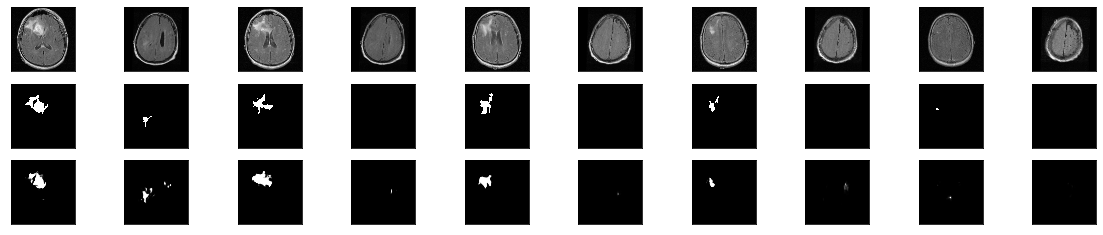

In [9]:
decoded_imgs = model.predict(x_test)
t = 256

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # MRI
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i+30].reshape(t, t))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Ground Truth
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(y_test[i+30].reshape(t, t))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Prediction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i+30].reshape(t, t))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig('Results.png')
plt.show()

# 150 epochs

In [0]:
model.save('Unet_2.h5')

In [0]:
weights = model.get_weights()
model.save_weights('Unet_2_Weights.h5')